# Lab 3: Bayes Classifier and Boosting

## Import the libraries

In [1]:
import numpy as np
from scipy import misc
from importlib import reload
from labfuns import *
import random

/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_95259/419916758.py:2: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


## Assignment 1

In [2]:
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

  # Map each sample to its class index [0..Nclasses-1]
    inv = np.searchsorted(classes, labels.reshape(-1))

    # Counts per class Nk (C x 1 for broadcasting)
    Nk = np.bincount(inv, minlength=Nclasses).astype(float).reshape(Nclasses, 1)

    # Class-wise sums -> means (ML)
    np.add.at(mu, inv, X)
    mu /= Nk

    # Per-class squared deviations -> variances (diagonal ML)
    dif = X - mu[inv]                       # broadcast μ_k to each row
    var_sum = np.zeros((Nclasses, Ndims))
    np.add.at(var_sum, inv, dif * dif)
    var = var_sum / Nk                      # divisor Nk (ML, not Nk-1)

    # Build diagonal covariance matrices
    idx = np.arange(Ndims)
    sigma[:, idx, idx] = var

    return mu, sigma

In [3]:
# 1) Generate test data
X, labels = genBlobs()                

# 2) ML estimates (means and diagonal covariances)
mu, sigma = mlParams(X, labels)

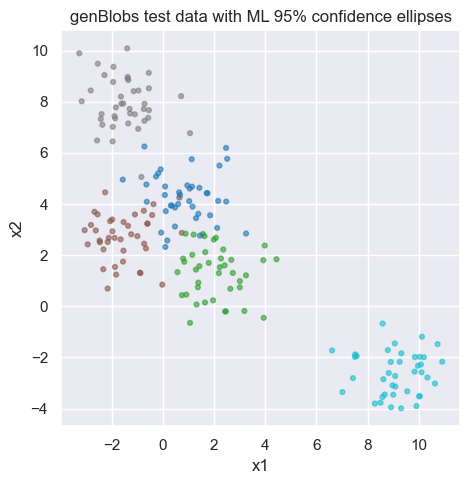

In [4]:
# 3) Plot points + 95% confidence ellipses
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels, s=12, alpha=0.6, cmap='tab10')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("genBlobs test data with ML 95% confidence ellipses")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()

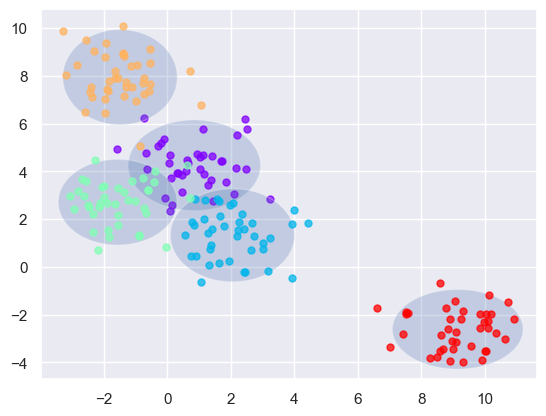

In [5]:
plotGaussian(X,labels,mu,sigma)           # uses 95% CI internally (per the lab)

## Assignment 2

In [6]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts, 1)) / float(Npts)  # uniform weights → count/N
    else:
        assert (W.shape[0] == Npts)
        if W.ndim == 1:
            W = W.reshape(-1, 1)

    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses, 1))

    # Map labels to compact indices 
    inv = np.searchsorted(classes, labels.reshape(-1))

    # Sum weights per class → prior (with uniform W this is Nk/N)
    np.add.at(prior, inv, W)

    # Safety: ensure priors sum to 1
    s = prior.sum()
    if s > 0:
        prior /= s

    return prior

In [7]:
def classifyBayes(X, prior, mu, sigma):
    Npts, Ndims = X.shape
    Nclasses = mu.shape[0]

    # Extract the diagonal variances for each class (shape: C x d)
    var = np.diagonal(sigma, axis1=1, axis2=2)
    var = np.maximum(var, 1e-12)  # avoid division by zero

    # Precompute constants for the Gaussian log-likelihood
    const = -0.5 * Ndims * np.log(2.0 * np.pi)        # constant term per class
    logdet = np.sum(np.log(var), axis=1)              # log |Σ_k| = sum of log variances
    inv_var = 1.0 / var                               # (C x d) reciprocal variances

    # Broadcasting shapes: (C,1,d) - (1,N,d) → (C,N,d)
    diff = X[None, :, :] - mu[:, None, :]
    quad = np.sum((diff * diff) * inv_var[:, None, :], axis=2)  # shape: (C,N)

    # Compute log-likelihood for each class and data point:
    # log N(x|μ_k,Σ_k) = const - 0.5 * (quad + log|Σ_k|)
    loglike = const - 0.5 * (quad + logdet[:, None])

    # Compute log-prior for each class
    # Add a small epsilon to avoid log(0)
    logprior = np.log(np.maximum(prior.reshape(-1, 1), 1e-300))

    # Combine likelihood and prior → log posterior (up to normalization)
    # log p(k|x) ∝ log p(x|k) + log p(k)
    logProb = logprior + loglike                       # shape: (C,N)

    # Choose the most probable class per sample (MAP)
    h = np.argmax(logProb, axis=0)

    return h


## Assignment 3

In [8]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

In [9]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [10]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

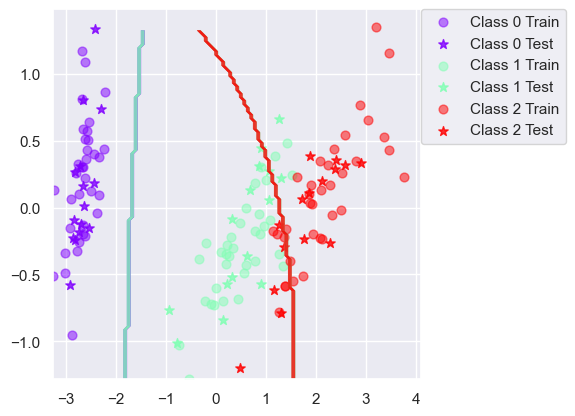

In [11]:
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

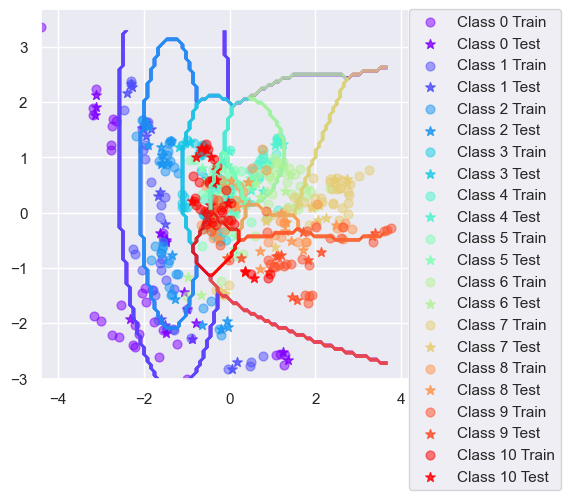

In [12]:
plotBoundary(BayesClassifier(), dataset='vowel',split=0.7)

The feature independence assumption can be reasonable when features are weakly correlated or describe unrelated aspects of the data, since the diagonal covariance approximation is then accurate. It becomes unreasonable when features are highly correlated, as in the Iris dataset, because ignoring their dependence prevents the model from capturing the real class structure.

The decision boundaries for the Iris dataset are smooth but rigid and mostly axis-aligned, reflecting the diagonal covariance assumption. Although the model performs well because the classes are clearly separated, accuracy could be improved by allowing full covariance matrices, using a discriminative classifier (e.g. SVM or Logistic Regression), or applying PCA to decorrelate the features.

## Assignment 4

In [13]:
def mlParams(X, labels, W):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)
    else:
        W = W.reshape(-1, 1)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

  # Map each sample to its class index [0..Nclasses-1]
    inv = np.searchsorted(classes, labels.reshape(-1))

    # Total Wk count per class
    Wk = np.zeros((Nclasses, 1))
    np.add.at(Wk, inv, W)

    # Mean calculation with weights
    weighted_sum = np.zeros((Nclasses, Ndims))
    np.add.at(weighted_sum, inv, X * W)
    mu = weighted_sum / Wk

    # Diagonal variance calculation with weights
    dif = X - mu[inv]                       # broadcast μ_k to each row
    var_sum = np.zeros((Nclasses, Ndims))
    np.add.at(var_sum, inv, W*(dif**2))
    var = var_sum / Wk                     

    # Build diagonal covariance matrices
    idx = np.arange(Ndims)
    sigma[:, idx, idx] = var

    return mu, sigma

In [14]:
# 1) Generate test data
X, labels = genBlobs()                

# 2) ML estimates (means and diagonal covariances)
W = np.ones((X.shape[0], 1)) / X.shape[0]
mu, sigma = mlParams(X, labels, W)

#np.allclose(mu1, mu), np.allclose(sigma1, sigma)

## Assignment 5

In [15]:
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X).reshape(-1,1)

        # compute the weighted error rate of this classifier
        incorrect = (vote != labels.reshape(-1,1)).astype(float)
        err = np.sum(wCur * (incorrect))

        # calculate alpha
        alpha = 0.5 * np.log((1 - err) / err)

        alphas.append(alpha)

        #update weights
        wCur = wCur * np.exp(alpha * (2 * incorrect - 1))

        # re-normalize weights
        wCur = wCur / np.sum(wCur)
        
    return classifiers, alphas

In [16]:
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # accumulate the votes from each classifier
        for t in range(Ncomps):
            vote = classifiers[t].classify(X).reshape(-1)
            for k in range(Nclasses):
                votes[:,k] += alphas[t] * (vote == k).astype(float)

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

In [17]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

In [18]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_95259/1867638332.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = 0.5 * np.log((1 - err) / err)
/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_95259/1867638332.py:31: RuntimeWarning: invalid value encountered in divide
  wCur = wCur / np.sum(wCur)
/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_95259/628558435.py:15: RuntimeWarning: invalid value encountered in multiply
  votes[:,k] += alphas[t] * (vote == k).astype(float)


Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.1 with standard deviation 6.72


In [19]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

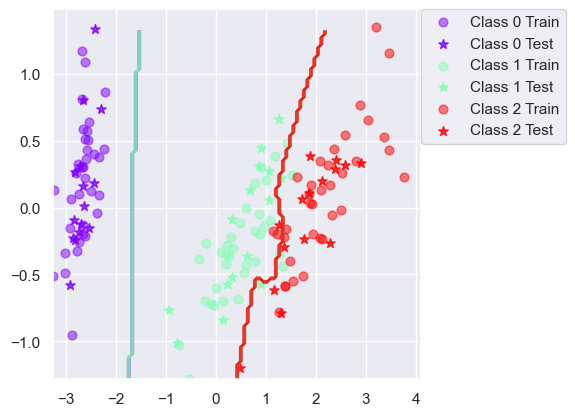

In [20]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

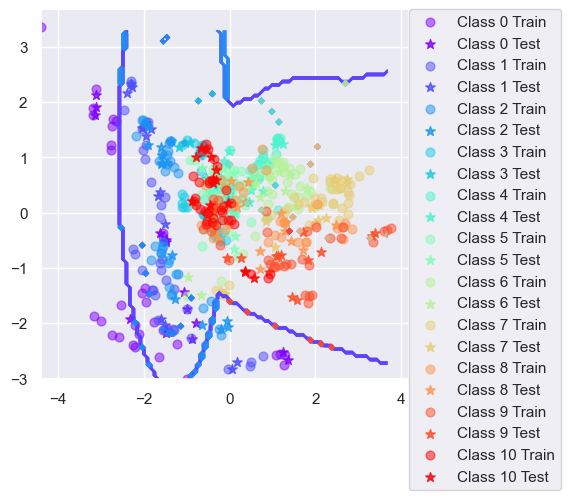

In [21]:
plotBoundary(BoostClassifier(BayesClassifier()), dataset='vowel',split=0.7)

1) There was an improvement in accuracy for iris dataset using the AdaBoost algorithm from 89% to 94.1%, and for the vowel dataset from 64.7% to 80.2%. This is because AdaBoost combines multiple weak classifiers to create a stronger ensemble. Each new classifier focuses on the misclassified samples from previous classifiers, reducing bias and variance. As a result, the ensemble can capture more complex decision boundaries and improve overall accuracy.

2) The decision boundaries became more complex and better aligned with the true class distributions after applying AdaBoost, specially in regions where classses overlap. This reflects the main strength of boosting, the ability to approximate non-linear decision boundaries using many weak learners.

3) Boosting can partially make up for not using a more advanced model by combining multiple weak classifiers to create a stronger ensemble. This can improve accuracy and decision boundaries, especially when the base model is simple. However, boosting cannot fully compensate for the limitations of a weak base model. If the base model is too simplistic or biased, the ensemble may still struggle to capture complex patterns in the data. 

## Assignment 6

In [22]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.67


In [23]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [24]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4.02


In [25]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.7
Trial: 10 Accuracy 90.3
Trial: 20 Accuracy 87
Trial: 30 Accuracy 90.9
Trial: 40 Accuracy 83.8
Trial: 50 Accuracy 79.9
Trial: 60 Accuracy 91.6
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 88.3
Trial: 90 Accuracy 85.1
Final mean classification accuracy  86.5 with standard deviation 3.06


/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

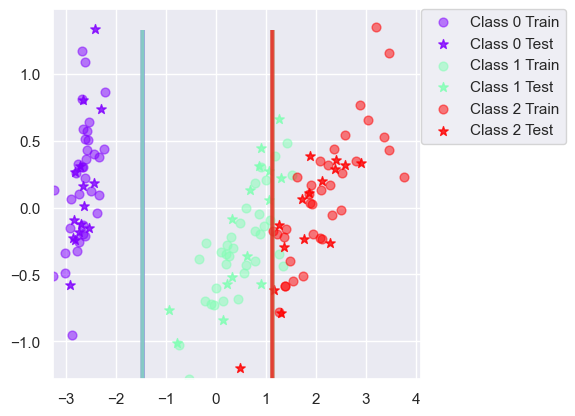

In [26]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

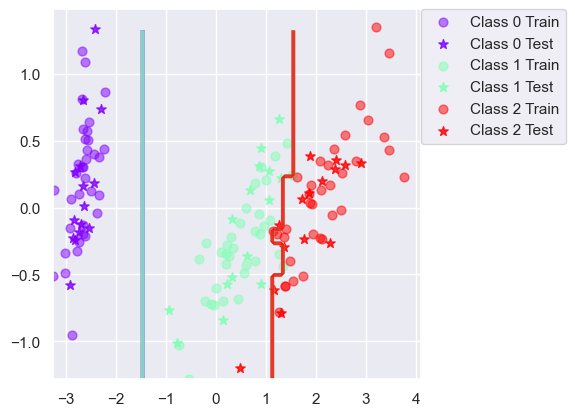

In [27]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

1) There was an improvement in accuracy for both datasets using AdaBoost, for the iris dataset from 92.4% to 94.6%, and for the vowel dataset from 64.1% to 86.5%. But for the iris dataset we can see that even without boosting the accuracy was already higher than with the Bayes classifier. We can again see that boosting helps improve accuracy by combining multiple weaker classifiers to create a stronger ensemble that can capture more complex patterns in the data.

2) The decision boundaries on the graph became more complex again and better aligned with the true class distributions after applying AdaBoost. 

3) With decision trees as base classifiers we can see that the accuracy without boosting is already higher than with the Bayes classifier, and with boosting it improves even more. So we still cannot fully make up for not using a more advanced model, but using decision trees as base classifiers is a step in the right direction.

## Assignment 7

If we had to pick one of the classifiers as the best overall, we would choose the boosted decision tree classifier. This is because it achieved the highest accuracy on both datasets and still managed to have a lower standard deviation compared to the boosted Bayes classifier. Decision trees are better with irrelevant inputs because they can ignore them when making splits, while Bayes classifiers consider all features equally and boosting enhances this by focusing on misclassified samples. While Bayes classifiers relies on probabilistic estimates that can be strongly affected by outliers, decision trees are more robust to such anomalies. Both classifiers can handle mixed types of data, but decision trees can naturally handle categorical features. Naive Bayes may be faster and more scalable for very large datasets, but decision trees can still be efficient with proper implementations, especially when accuracy is the main objective rather than speed.

## Bonus

In [38]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.8, dim=30)

Trial: 0 Accuracy 91.2
Trial: 10 Accuracy 91.2
Trial: 20 Accuracy 95
Trial: 30 Accuracy 93.8
Trial: 40 Accuracy 90
Trial: 50 Accuracy 85
Trial: 60 Accuracy 88.8
Trial: 70 Accuracy 86.2
Trial: 80 Accuracy 90
Trial: 90 Accuracy 91.2
Final mean classification accuracy  91 with standard deviation 2.81


In [33]:
testClassifier(BoostClassifier(DecisionTreeClassifier(),T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 79.2
Trial: 10 Accuracy 69.2
Trial: 20 Accuracy 72.5
Trial: 30 Accuracy 68.3
Trial: 40 Accuracy 75
Trial: 50 Accuracy 67.5
Trial: 60 Accuracy 78.3
Trial: 70 Accuracy 73.3
Trial: 80 Accuracy 53.3
Trial: 90 Accuracy 72.5
Final mean classification accuracy  69.8 with standard deviation 6.76


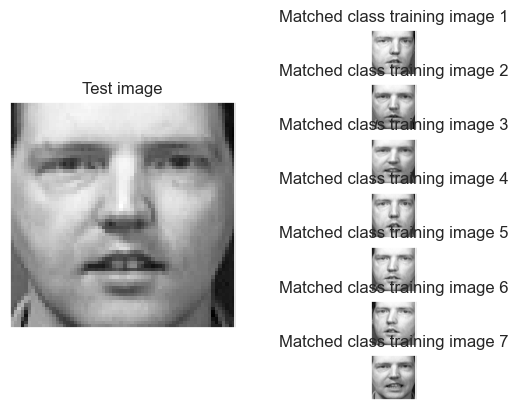

In [39]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])